# Data visualization around the Grenoble 2020 elections - followers & friends

## Loading the data

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
import pandas
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import twitter as tw

/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [2]:
users = {
    'EricPiolle': 'Grenoble en Commun',
    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
}
names = {
    'EricPiolle': 'Éric Piolle',
    'EmilieCChalas': 'Emilie Chalas',
    'CarignonAlain': 'Alain Carignon',
    'onoblecourt': 'Olivier Noblecourt',
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',    
}
colors2 = {names[n]: colors[users[n]] for n in names}

In [3]:
follower_files = [
    'followers/CarignonAlain.csv',
    'followers/EmilieCChalas.csv',
    'followers/onoblecourt.csv',
    'followers/EricPiolle.csv',
]

friend_files = [
    'friends/CarignonAlain.csv',
    'friends/EmilieCChalas.csv',
    'friends/onoblecourt.csv',
    'friends/EricPiolle.csv',
]

filenames = follower_files + friend_files

data = []
for f in filenames:
    login = f.split('/')[1].split('.')[0]
    relation = f.split('/')[0]
    tmp = pandas.read_csv(f)
    tmp['relation'] = relation
    tmp['candidate_login'] = login
    tmp['candidate_name'] = names[login]
    tmp['candidate_tag'] = users[login]
    data.append(tmp)
df = pandas.concat(data)
df['date'] = pandas.to_datetime(df['date'])

print(len(df), len(df.columns))

58904 19


In [4]:
df.groupby('candidate_name')[['date']].agg(['min', 'max', 'count'])

date                           
                                   min                 max  count
candidate_name                                                   
Alain Carignon     2007-01-02 01:48:14 2020-02-24 09:12:58   7272
Emilie Chalas      2007-03-28 12:14:38 2020-02-27 15:15:41   7137
Olivier Noblecourt 2006-12-08 15:00:33 2020-02-24 09:12:58   6404
Éric Piolle        2006-12-08 07:58:42 2020-02-27 20:40:58  38091

## Followers sharing

In [5]:
def compute_sharing_matrix(df):
    tmp = []
    for c1 in df['candidate_name'].unique():
        for c2 in df['candidate_name'].unique():
            nb = len(set(df[df['candidate_name'] == c1]['id']) & set(df[df['candidate_name'] == c2]['id']))
            total = len(df[df['candidate_name'] == c1])
            percent = nb/total * 100
            txt_a = f'{percent:.1f}%' if percent < 100 else ''
            txt_b = f'{nb}/{total}' if percent < 100 else ''
            txt = f'{txt_b}\n{txt_a}'
            if c1 == c2:
                nb = 0
                percent = 0
            tmp.append({
                'candidate': c1,
                'other': c2,
                'nb_common': nb,
                'percent_shared': percent,
                'text': txt
            })
    return pandas.DataFrame(tmp)
shared_followers = compute_sharing_matrix(df[df['relation'] == 'followers'])
shared_followers

,candidate,other,nb_common,percent_shared,text
0,Alain Carignon,Alain Carignon,0,0.000000,\n
1,Alain Carignon,Emilie Chalas,483,17.237687,483/2802\n17.2%
2,Alain Carignon,Olivier Noblecourt,322,11.491792,322/2802\n11.5%
3,Alain Carignon,Éric Piolle,844,30.121342,844/2802\n30.1%
4,Emilie Chalas,Alain Carignon,483,7.142857,483/6762\n7.1%
5,Emilie Chalas,Emilie Chalas,0,0.000000,\n
6,Emilie Chalas,Olivier Noblecourt,820,12.126590,820/6762\n12.1%
7,Emilie Chalas,Éric Piolle,1193,17.642709,1193/6762\n17.6%
8,Olivier Noblecourt,Alain Carignon,322,5.496757,322/5858\n5.5%
9,Olivier Noblecourt,Emilie Chalas,820,13.997952,820/5858\n14.0%


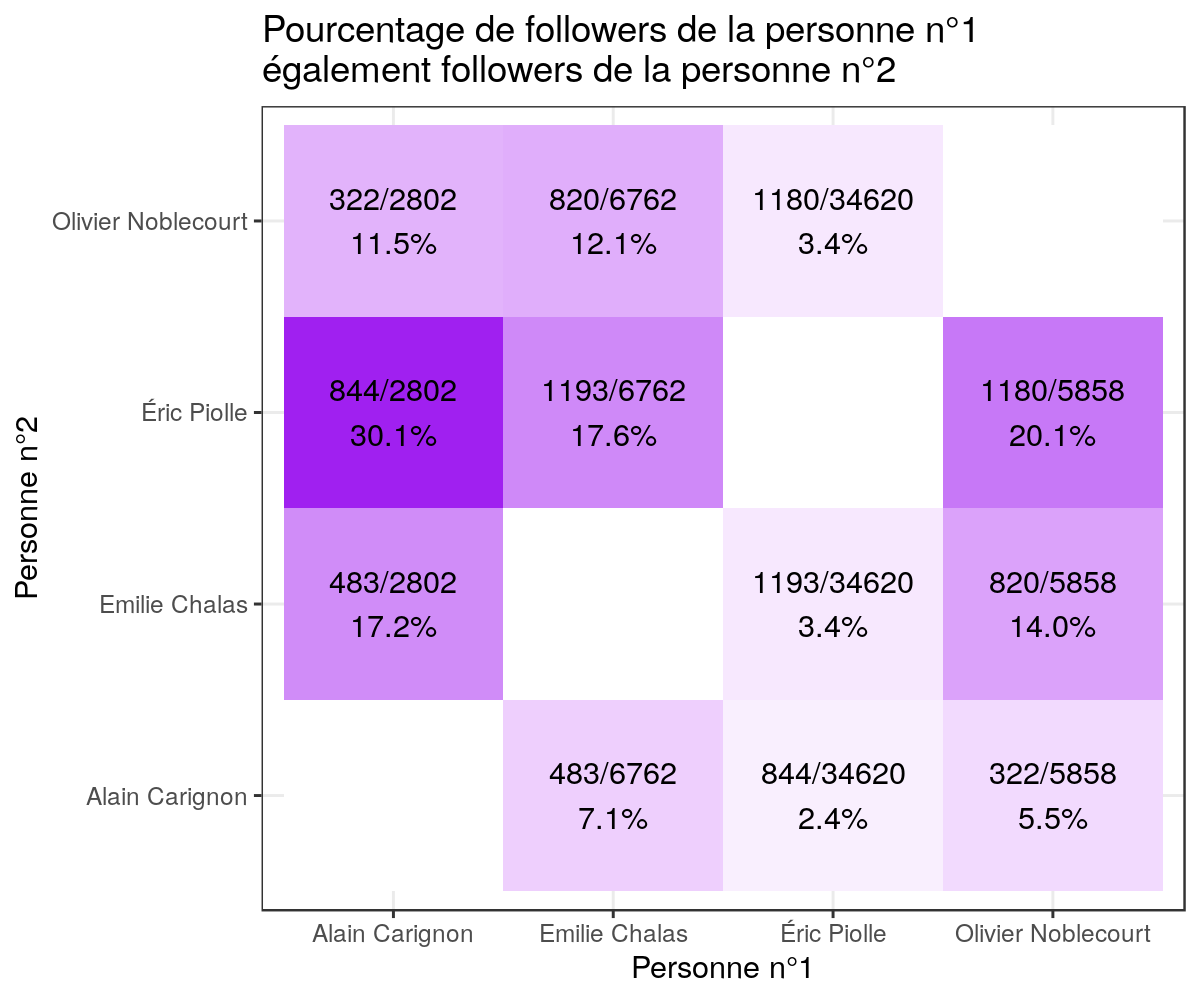

In [6]:
%%R -i shared_followers -w 6 -h 5 --units in -r 200

library(ggplot2)

plot = ggplot(shared_followers) +
    aes(x=candidate, y=other, fill=percent_shared) +
    geom_tile() +
    theme_bw() +
    scale_fill_gradient2(high = "purple") +
    geom_text(aes(label = text), color = "black") +
    xlab('Personne n°1') +
    ylab('Personne n°2') +
    theme(legend.position='none') +
    ggtitle('Pourcentage de followers de la personne n°1\négalement followers de la personne n°2')
#ggsave('/tmp/shared_followers.png', plot, width=6, height=5)
plot

## Shared friends

In [7]:
shared_friends = compute_sharing_matrix(df[df['relation'] == 'friends'])
shared_friends

,candidate,other,nb_common,percent_shared,text
0,Alain Carignon,Alain Carignon,0,0.000000,\n
1,Alain Carignon,Emilie Chalas,144,3.221477,144/4470\n3.2%
2,Alain Carignon,Olivier Noblecourt,91,2.035794,91/4470\n2.0%
3,Alain Carignon,Éric Piolle,436,9.753915,436/4470\n9.8%
4,Emilie Chalas,Alain Carignon,144,38.400000,144/375\n38.4%
5,Emilie Chalas,Emilie Chalas,0,0.000000,\n
6,Emilie Chalas,Olivier Noblecourt,56,14.933333,56/375\n14.9%
7,Emilie Chalas,Éric Piolle,106,28.266667,106/375\n28.3%
8,Olivier Noblecourt,Alain Carignon,91,16.666667,91/546\n16.7%
9,Olivier Noblecourt,Emilie Chalas,56,10.256410,56/546\n10.3%


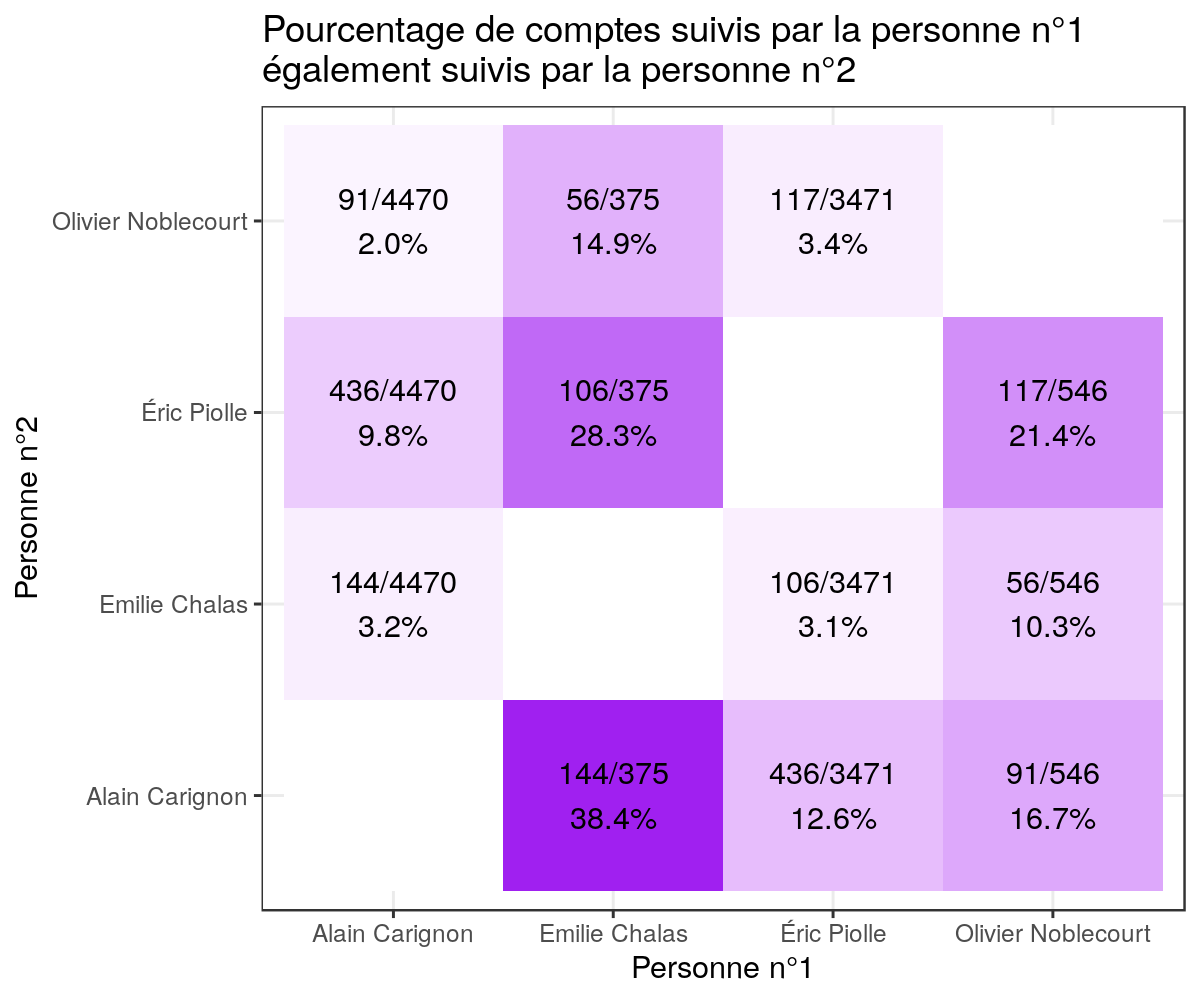

In [8]:
%%R -i shared_friends -w 6 -h 5 --units in -r 200

library(ggplot2)

plot = ggplot(shared_friends) +
    aes(x=candidate, y=other, fill=percent_shared) +
    geom_tile() +
    theme_bw() +
    scale_fill_gradient2(high = "purple") +
    geom_text(aes(label = text), color = "black") +
    xlab('Personne n°1') +
    ylab('Personne n°2') +
    theme(legend.position='none') +
    ggtitle('Pourcentage de comptes suivis par la personne n°1\négalement suivis par la personne n°2')
#ggsave('/tmp/shared_followers.png', plot, width=6, height=5)
plot

## Localisation

In [9]:
import re

def count_locations(df, locations):
    df = df.copy()
    df.loc[df['location'].isna(), 'location'] = 'no_location'
    result = []
    for login in df['candidate_login'].unique():
        tmp = df[df['candidate_login'] == login]
        for loc in locations:
            loc = '|'.join(loc)
            nb_loc = len(tmp['location'].str.extractall(r'(?P<ville>%s)' % loc, re.IGNORECASE))
            nb_total = len(tmp)
            result.append({
                'login': login,
                'name': names[login],
                'tag': users[login],
                'location': loc,
                'count': nb_loc,
                'percent': nb_loc/nb_total*100,
            })
    result = pandas.DataFrame(result)
    return result


def count_locations_fr(df):
    locations = count_locations(df, [['Grenoble'], ['Paris']])
    others = count_locations(df, [['Nantes', 'Rennes', 'Bordeaux', 'Strasbourg', 'Toulouse', 'Marseille', 'Montpellier', 'Nice', 'Lyon']])
    others['location'] = 'Autres grandes villes FR'
    noloc = count_locations(df, [['no_location']])
    noloc['location'] = 'Non spécifiée'
    locations = pandas.concat([locations, others, noloc])
    return locations

locations = count_locations_fr(df[df['relation'] == 'followers'])
locations

,login,name,tag,location,count,percent
0,CarignonAlain,Alain Carignon,Grenoble le Changement,Grenoble,396,14.132762
1,CarignonAlain,Alain Carignon,Grenoble le Changement,Paris,209,7.458958
2,EmilieCChalas,Emilie Chalas,Un Nouveau Regard sur Grenoble,Grenoble,474,7.009760
3,EmilieCChalas,Emilie Chalas,Un Nouveau Regard sur Grenoble,Paris,930,13.753327
4,onoblecourt,Olivier Noblecourt,Grenoble Nouvel Air,Grenoble,402,6.862410
5,onoblecourt,Olivier Noblecourt,Grenoble Nouvel Air,Paris,1162,19.836122
6,EricPiolle,Éric Piolle,Grenoble en Commun,Grenoble,3685,10.644136
7,EricPiolle,Éric Piolle,Grenoble en Commun,Paris,2230,6.441363
0,CarignonAlain,Alain Carignon,Grenoble le Changement,Autres grandes villes FR,168,5.995717
1,EmilieCChalas,Emilie Chalas,Un Nouveau Regard sur Grenoble,Autres grandes villes FR,389,5.752736


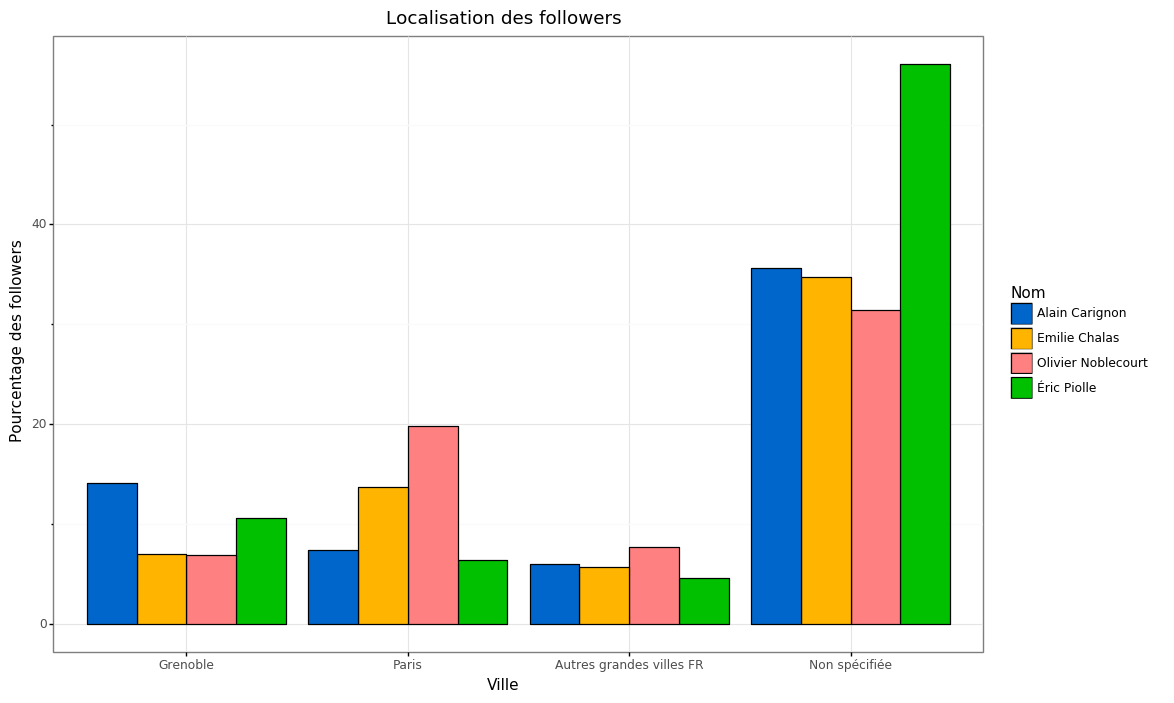

<ggplot: (8745567853958)>

In [10]:
ggplot(locations) +\
    aes(x='location', y='percent', group='name') +\
    geom_bar(aes(fill='name', group='name'), stat='identity', color='black', position='dodge') +\
    theme_bw() +\
    scale_fill_manual(colors2) +\
    ylab('Pourcentage des followers') +\
    xlab('Ville') +\
    labs(fill='Nom') +\
    scale_x_discrete(limits=['Grenoble', 'Paris', 'Autres grandes villes FR', 'Non spécifiée']) +\
    ggtitle('Localisation des followers')

## Mutual follows

In [11]:
followers = df[df['relation'] == 'followers'].set_index(['screen_name', 'candidate_login'])
friends = df[df['relation'] == 'friends'].set_index(['screen_name', 'candidate_login'])
mutuals = followers.join(friends, how='inner', rsuffix='_').reset_index()
print(len(followers))
print(len(friends))
print(len(mutuals))

50042
8862
3701


In [12]:
shared_mutuals = compute_sharing_matrix(mutuals)
shared_mutuals

,candidate,other,nb_common,percent_shared,text
0,Éric Piolle,Éric Piolle,0,0.000000,\n
1,Éric Piolle,Alain Carignon,115,5.442499,115/2113\n5.4%
2,Éric Piolle,Olivier Noblecourt,74,3.502130,74/2113\n3.5%
3,Éric Piolle,Emilie Chalas,50,2.366304,50/2113\n2.4%
4,Alain Carignon,Éric Piolle,115,11.819116,115/973\n11.8%
5,Alain Carignon,Alain Carignon,0,0.000000,\n
6,Alain Carignon,Olivier Noblecourt,22,2.261048,22/973\n2.3%
7,Alain Carignon,Emilie Chalas,39,4.008222,39/973\n4.0%
8,Olivier Noblecourt,Éric Piolle,74,18.500000,74/400\n18.5%
9,Olivier Noblecourt,Alain Carignon,22,5.500000,22/400\n5.5%


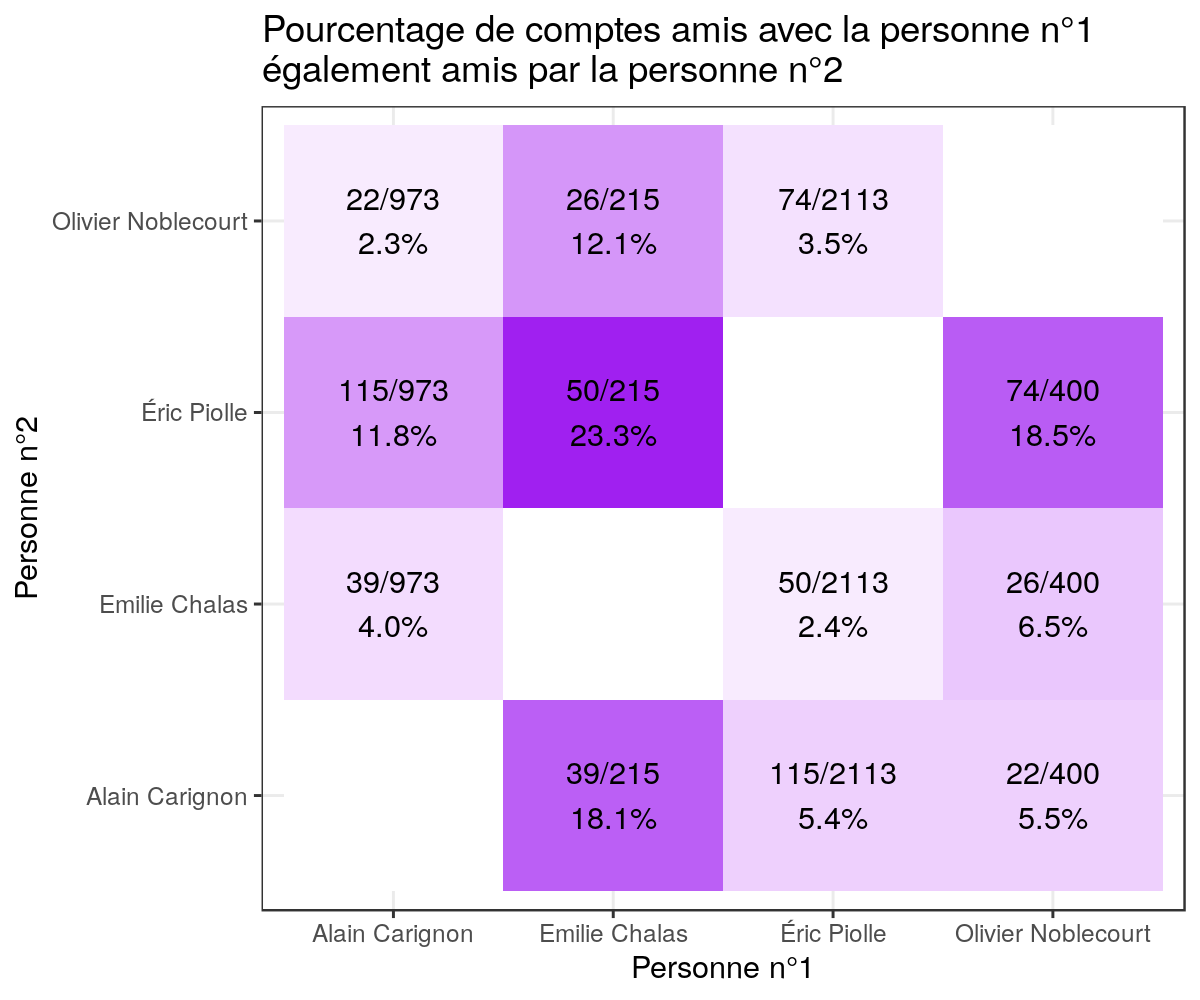

In [13]:
%%R -i shared_mutuals -w 6 -h 5 --units in -r 200

plot = ggplot(shared_mutuals) +
    aes(x=candidate, y=other, fill=percent_shared) +
    geom_tile() +
    theme_bw() +
    scale_fill_gradient2(high = "purple") +
    geom_text(aes(label = text), color = "black") +
    xlab('Personne n°1') +
    ylab('Personne n°2') +
    theme(legend.position='none') +
    ggtitle('Pourcentage de comptes amis avec la personne n°1\négalement amis par la personne n°2')
#ggsave('/tmp/shared_followers.png', plot, width=6, height=5)
plot

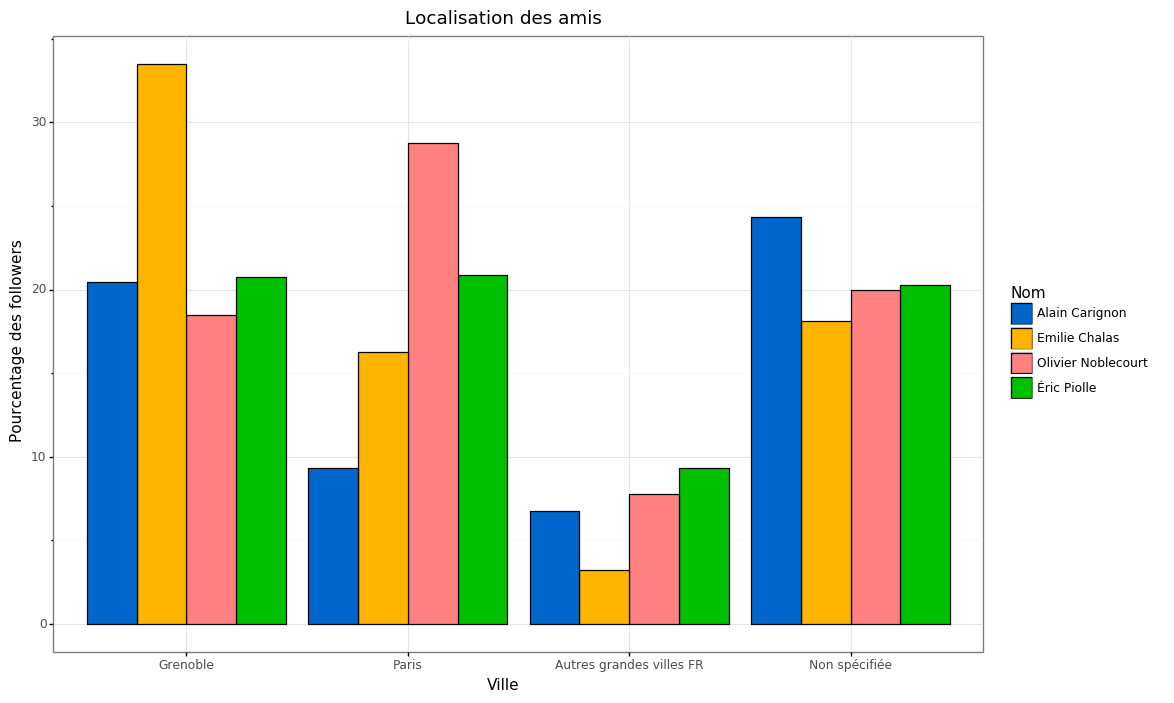

<ggplot: (8745568690517)>

In [14]:
locations = count_locations_fr(mutuals)
ggplot(locations) +\
    aes(x='location', y='percent', group='name') +\
    geom_bar(aes(fill='name', group='name'), stat='identity', color='black', position='dodge') +\
    theme_bw() +\
    scale_fill_manual(colors2) +\
    ylab('Pourcentage des followers') +\
    xlab('Ville') +\
    labs(fill='Nom') +\
    scale_x_discrete(limits=['Grenoble', 'Paris', 'Autres grandes villes FR', 'Non spécifiée']) +\
    ggtitle('Localisation des amis')